In [1]:
import numpy as np
import scipy.stats as stats

%matplotlib inline

In [2]:
from tensorflow.contrib.distributions import MultivariateNormalDiag
import tensorflow as tf
sess = tf.Session()

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [4]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.tools.set_credentials_file(username='alexander-prutko', api_key='VocBkhjfvvSy6zHJ8789')

In [5]:
from scipy.stats import multivariate_normal

In [6]:
# параметры распределений
mu0X, mu0Y, sigma0 = -1., -1., 1.
mu1X, mu1Y, sigma1 = 1., 1., 2.

In [7]:
def sample(d0, d1, n=32):
    x0 = d0(n)
    x1 = d1(n)
    y0 = np.zeros((n, 1))
    y1 = np.ones((n, 1))
    return np.vstack([x0, x1]), np.vstack([y0, y1])   

In [8]:
d0 = lambda n : np.random.normal(loc=[mu0X, mu0Y], scale=[sigma0, sigma0], size = [n,2])
d1 = lambda n : np.random.normal(loc=[mu1X, mu1Y], scale=[sigma1, sigma1], size = [n,2])

In [9]:
nx, ny = (300, 300)
x_ = np.linspace(-10, 10, nx)
y_ = np.linspace(-10, 10, ny)
xv, yv = np.meshgrid(x_, y_)
F0 = multivariate_normal([mu0X, mu0Y], sigma0)
F1 = multivariate_normal([mu1X, mu1Y], sigma1)

grid_list = list(zip(xv.reshape(1,-1).tolist()[0], yv.reshape(1,-1).tolist()[0]))
grid = np.reshape(grid_list, (nx,ny,2))
f0 = F0.pdf(grid)
f1 = F1.pdf(grid)
ratio = f1 / (f1 + f0)

In [10]:
learning_rate = 0.01
initializer = tf.contrib.layers.xavier_initializer()
x = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y = tf.placeholder(shape=[None, 1], dtype=tf.float32)
# nn = tf.layers.dense(x, 10, activation=tf.nn.relu, kernel_initializer=initializer)
# nn = tf.layers.dense(nn, 10, activation=tf.nn.relu, kernel_initializer=initializer)
# nn = tf.layers.dense(nn, 10, activation=tf.nn.relu, kernel_initializer=initializer)
encoded = tf.layers.dense(x, 1, activation=None, kernel_initializer=initializer)

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=encoded)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

predicted = tf.nn.sigmoid(encoded)
correct_pred = tf.equal(tf.round(predicted), y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [11]:
with tf.Session() as sess:
    sess.run(init)
    for step in range(10000):
        a = sample(d0, d1, 1000)
        loss, _, acc = sess.run([cost, optimizer, accuracy],
                                   feed_dict={x: a[0], y: a[1]})
        if step % 1000 == 0:
            b = sample(d0, d1, 10000)
            loss, acc = sess.run([cost, accuracy],
                                   feed_dict={x: b[0], y: b[1]})
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step, loss, acc))
            
    pred = sess.run([predicted], feed_dict={x: grid.reshape(-1,2)})

Step:     0	Loss: 1.022	Acc: 45.12%
Step:  1000	Loss: 0.393	Acc: 83.81%
Step:  2000	Loss: 0.393	Acc: 83.72%
Step:  3000	Loss: 0.388	Acc: 83.88%
Step:  4000	Loss: 0.396	Acc: 83.68%
Step:  5000	Loss: 0.394	Acc: 83.86%
Step:  6000	Loss: 0.392	Acc: 83.93%
Step:  7000	Loss: 0.393	Acc: 83.64%
Step:  8000	Loss: 0.391	Acc: 83.61%
Step:  9000	Loss: 0.393	Acc: 83.83%


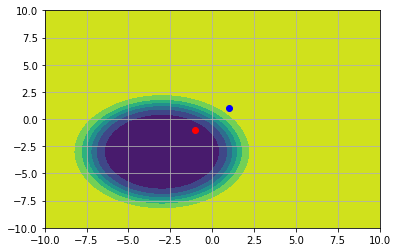

In [12]:
plt.contourf(x_,y_,ratio)
plt.scatter([-1],[-1], c='red')
plt.scatter([1],[1], c='blue')
plt.grid(True)

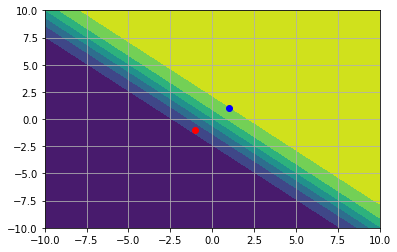

In [13]:
dist = pred[0].reshape(nx, ny)
dist = dist.reshape((nx,ny))
h = plt.contourf(x_,y_,dist)
plt.scatter([-1],[-1], c='red')
plt.scatter([1],[1], c='blue')
plt.grid(True)

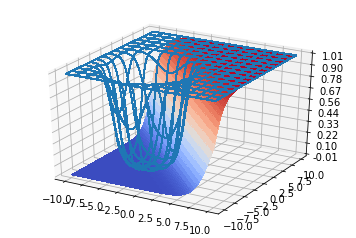

In [14]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf2 = ax.plot_surface(xv, yv, dist, cmap=cm.coolwarm, rstride=5, cstride=5,
                       linewidth=0, antialiased=False)
surf = ax.plot_wireframe(xv, yv, ratio, cmap=cm.coolwarm, rstride=20, cstride=20,
                       linewidth=1, antialiased=False)


ax.set_zlim(-0.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

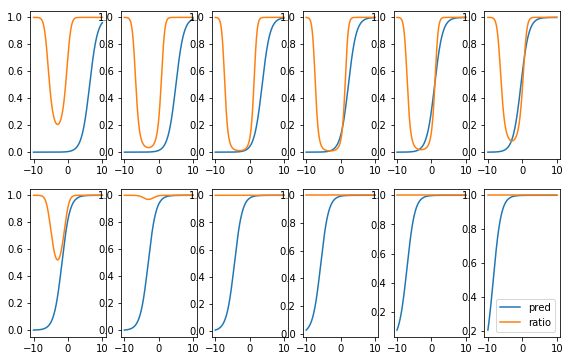

In [15]:
plt.rcParams['figure.figsize'] = [9.5, 6]
yy = 50
for i in range(12):
    plt.subplot(2, 6, i+1)
    plt.plot(x_, dist[yy+20*i,:], label='pred')
    plt.plot(x_, ratio[yy+20*i,:], label='ratio')
plt.legend();

In [16]:
data = [go.Surface(z=dist, x=xv, y=yv, opacity=1.00, colorscale='Greens'),
        go.Surface(z=ratio, x=xv, y=yv, opacity=0.8)]

In [17]:
py.iplot(data,filename='plot')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~alexander-prutko/0 or inside your plot.ly account where it is named 'plot'


[plotly plot](https://plot.ly/~alexander-prutko/0)